# Finding space wave for hollow core fiber

Also Debugging implementation of space wave.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from scipy import integrate
%matplotlib widget
plt.style.use('dark_background')

In [2]:
A = SlabExact(scale=1e-6, Ts=[5, 1, 5, 1, 5],
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[30, 20, 40, 20, 30],
              symmetric=True)

In [3]:
b = 1.25

def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x / b) ** 2, 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

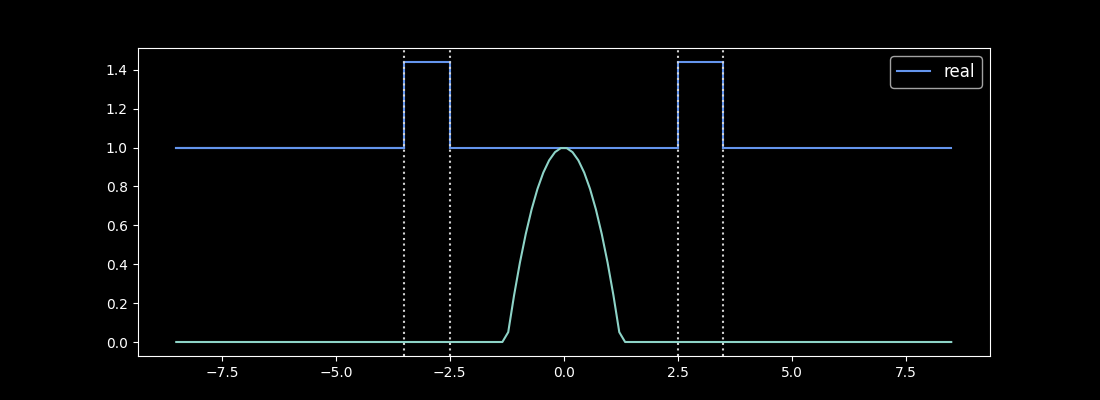

In [4]:
A.plot_refractive_index()
A.add_1d_plot(f0)

In [5]:
Z_base = 1e-4
dZ = 1e-7

Fp = A.dFdZ_approx(Z_base=Z_base, dZ=dZ)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

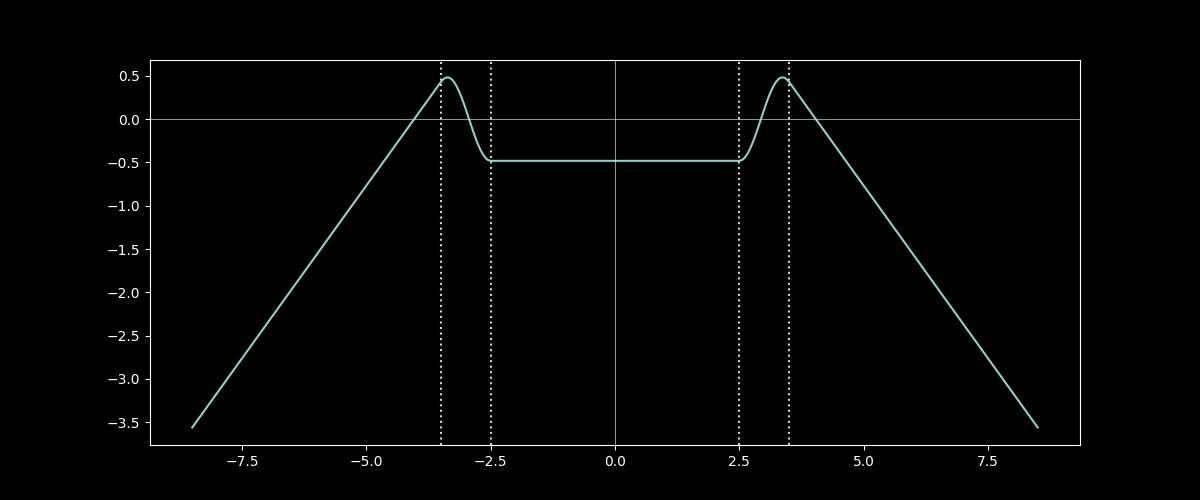

In [6]:
A.plot_field_1d(Fp)

In [7]:
SW = A.space_wave_approx(f0, Z_base=1e-5, dZ=1e-7, Lx=-b, Rx=b)

In [8]:
z0 = np.array([1e2])
x0 = 0

space_wave_x = lambda x, z0=z0: SW(x, z0)
space_wave_z = lambda z, x0=x0: SW(x0, z)

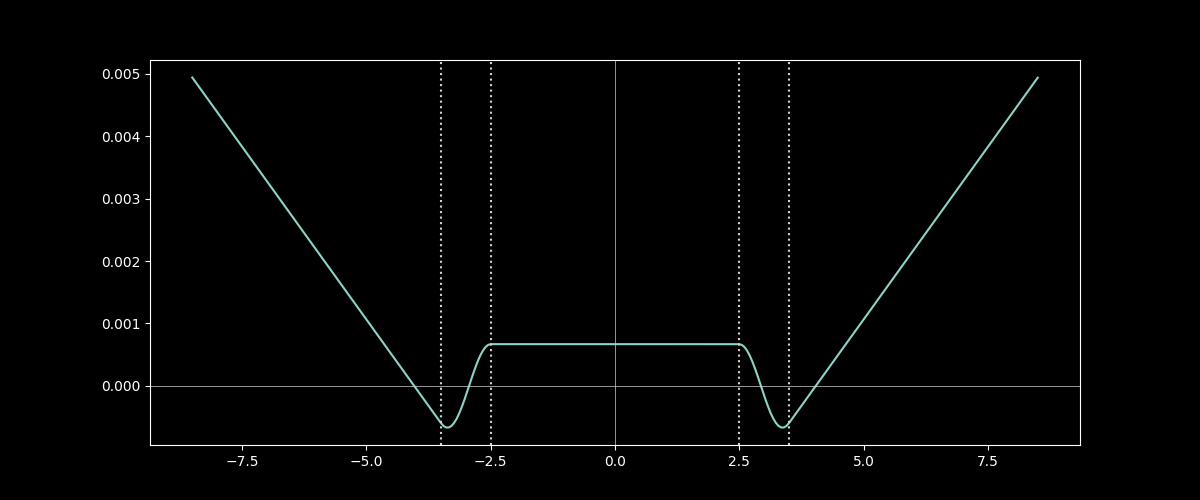

In [9]:
A.plot_field_1d(space_wave_x);

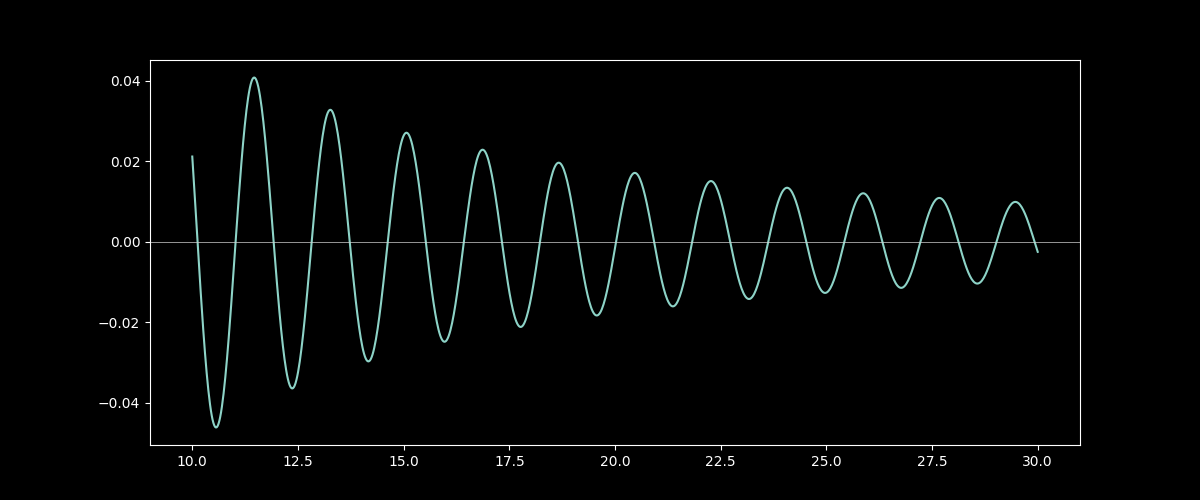

In [10]:
A.plot_field_1d(space_wave_z, xs=np.linspace(10, 30, 1000), plot_Rhos=False);

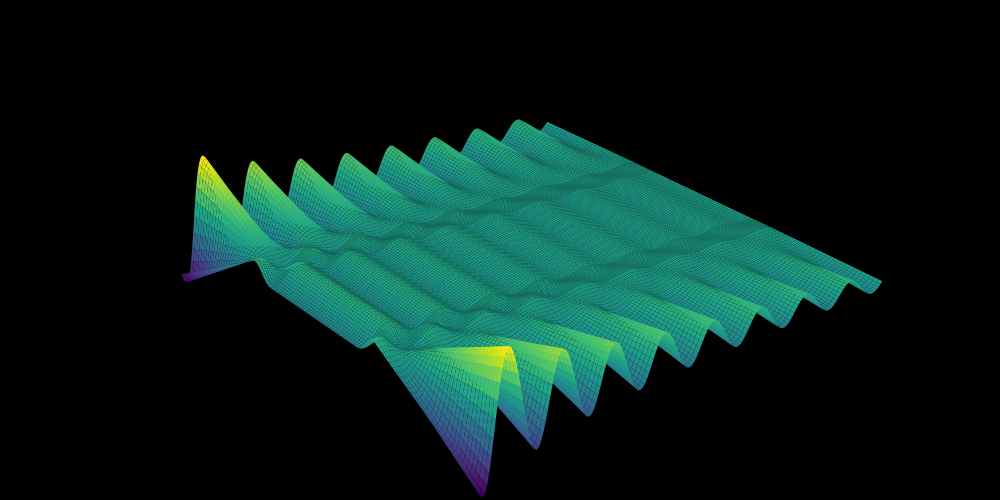

In [11]:
A.plot_field_2d_surface(SW, zmin=5, zmax=20, zref=200, rstride=1, cstride=1, elev=24, azim=-36);

# Compare to SDP integral

In [12]:
PC = A.propagator()

In [13]:
P_sdp1 = PC(A.sdp_contour(.0001, .75, 200), f0, Lx=-b, Rx=b)
P_sdp2 = PC(A.sdp_contour(.75, 5, 500), f0, Lx=-b, Rx=b)

P_sdps = [
    P_sdp1,
    P_sdp2,
]

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

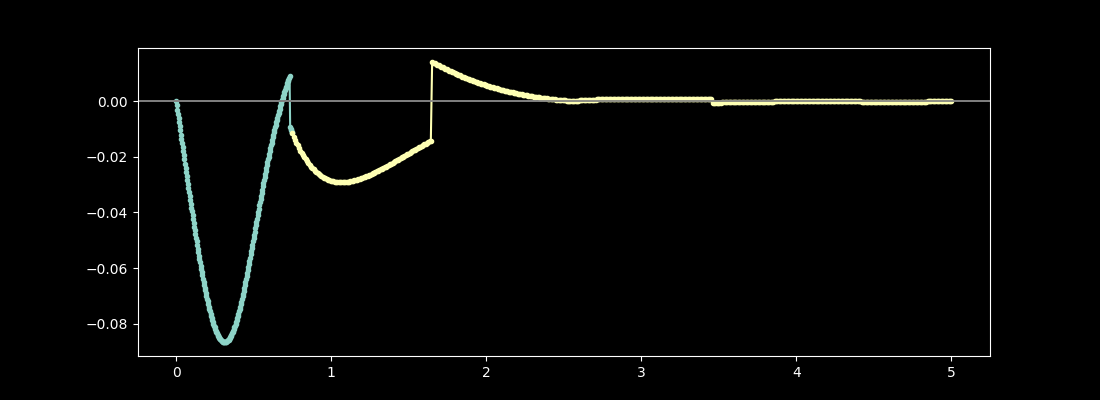

In [14]:
P_sdp1.plot_transform()
P_sdp2.plot_transform(ax=plt.gca())

## Plotting space wave

In [15]:
z0 =1000
x0 = 10

sdp_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_sdps])
sdp_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_sdps])

ratio_x = lambda x: sdp_x(x) / space_wave_x(x)
ratio_z = lambda z: sdp_z(z) / space_wave_z(z)

Sdp = lambda x, z: sum([P.propagate(x, z) for P in P_sdps])

In [16]:
xs = np.linspace(-6, 6, 2000)

### Cross section at z = z0

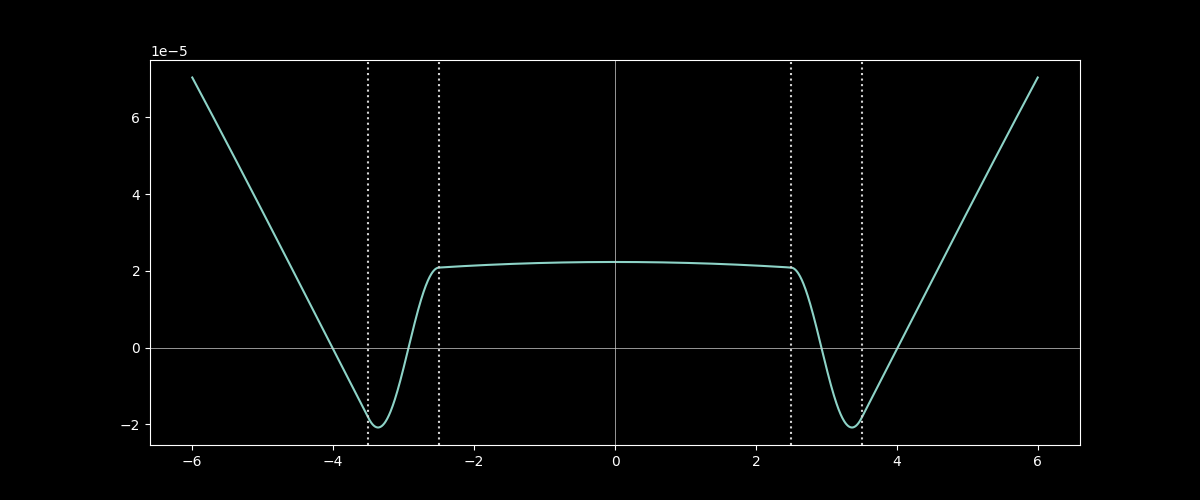

In [18]:
A.plot_field_1d(sdp_x, xs=xs);

### Surface from z=5 to z=20

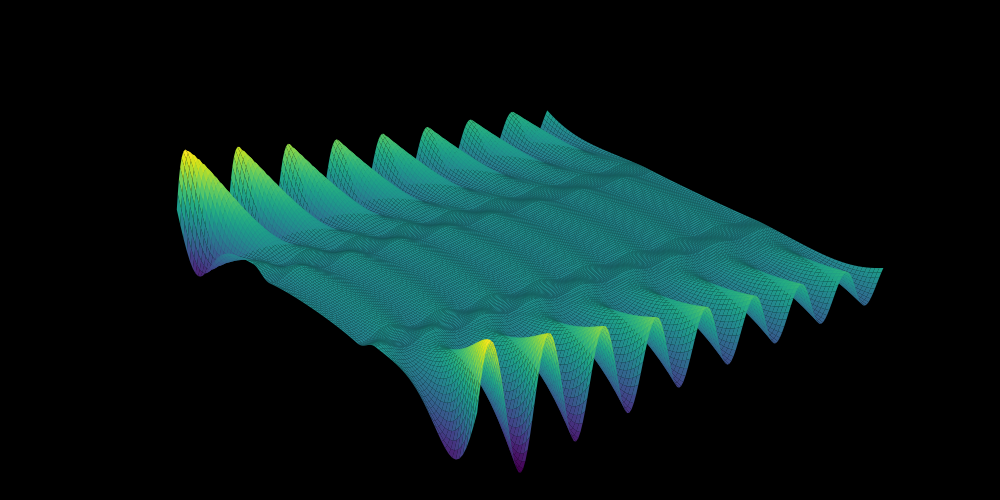

In [19]:
A.plot_field_2d_surface(Sdp, zmin=5, zmax=20, zref=200, rstride=1, cstride=1, elev=24, azim=-36);

## Comparing the two

In [20]:
x0 = 0

space_wave_z = lambda z, x0=x0: SW(x0, z)
sdp_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_sdps])


### z direction

(-5.0, 200.0)

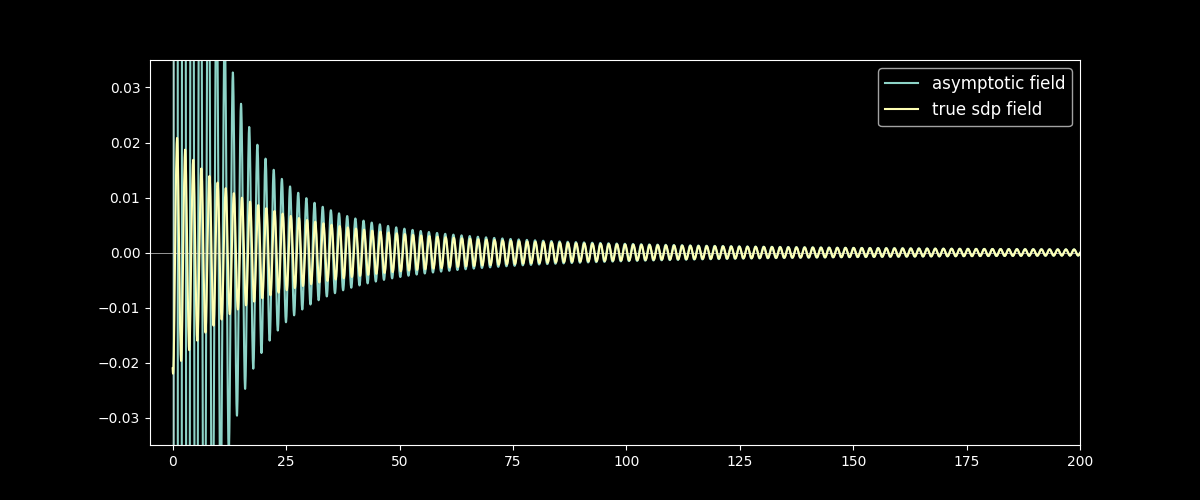

In [21]:
zs = np.linspace(.1, 200, 5000)
_, ax = A.plot_field_1d(space_wave_z, xs=zs, plot_Rhos=False, label='asymptotic field');
A.add_1d_plot(sdp_z, xs=np.linspace(0, 200, 5000), label='true sdp field')
ax.set_ylim(-.035, 0.035)
ax.set_xlim(-5, 200)

### x direction

In [43]:
z0 = 130
space_wave_x = lambda x, z0=z0: SW(x, z0)
sdp_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_sdps])

Text(0.5, 1.0, 'Comparison of SDP field and Asymptotic field at $z=130.00$')

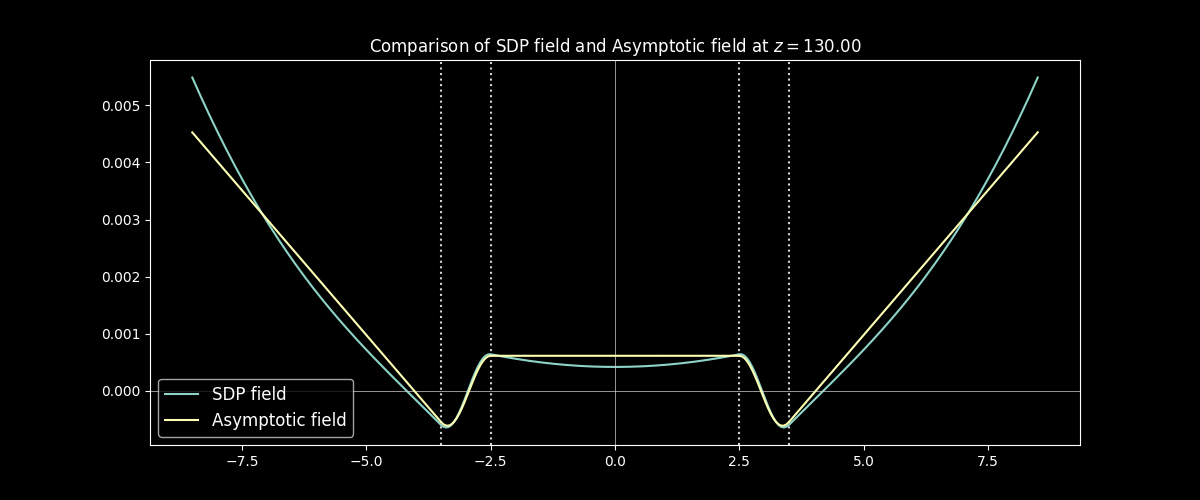

In [44]:
fig, ax = A.plot_field_1d(sdp_x, label='SDP field');
A.add_1d_plot(space_wave_x, label='Asymptotic field');
ax.set_title('Comparison of SDP field and Asymptotic field at $z=%.2f$' %z0)

## Trying to make the two match up

This was for when they weren't working.  Seems the Hu + Menyuk formula needed a factor of -$\pi$

In [24]:
exp_ikz = lambda z, s=1: -s * np.exp(1j * A.K0 * A.n0 * z)
root_z = lambda z, s=1: s * np.sqrt(A.K0 * A.n0  / z) ** 3
root_exp = lambda z, s=1: s * np.exp(1j * A.K0 * A.n0 * z) * np.sqrt(A.K0 * A.n0  / z) ** 3

### In the z-direction

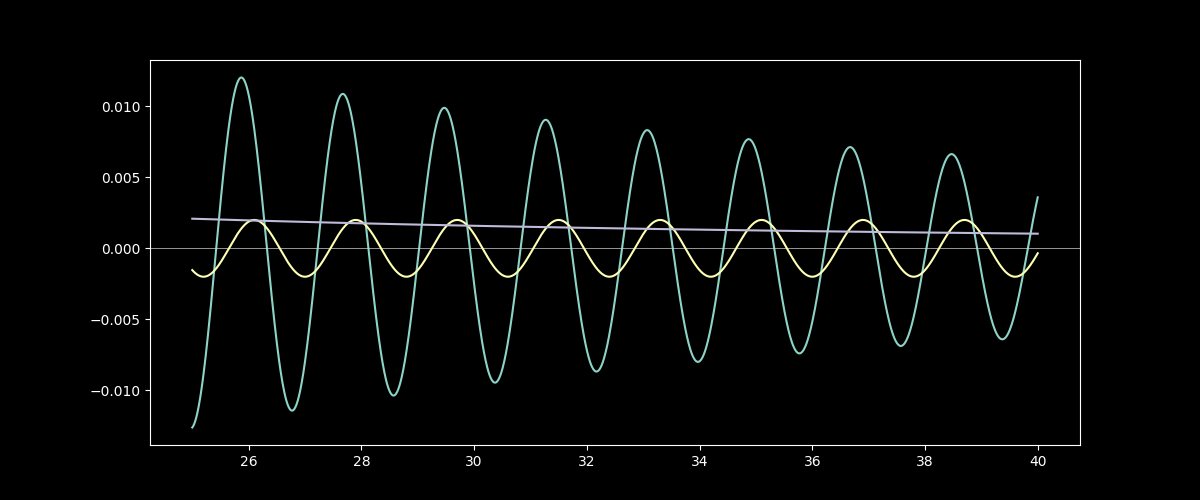

In [33]:
A.plot_field_1d(space_wave_z, xs=zs, plot_Rhos=False);
A.add_1d_plot(exp_ikz, .002, xs=zs)
A.add_1d_plot(root_z, .04, xs=zs)


In [101]:
zs2 = np.linspace(500, 600, 1000)
scalar = np.mean(sdp_z(zs2)/root_exp(zs2))
scalar

(-1.541264511207823-1.8388436003557318j)

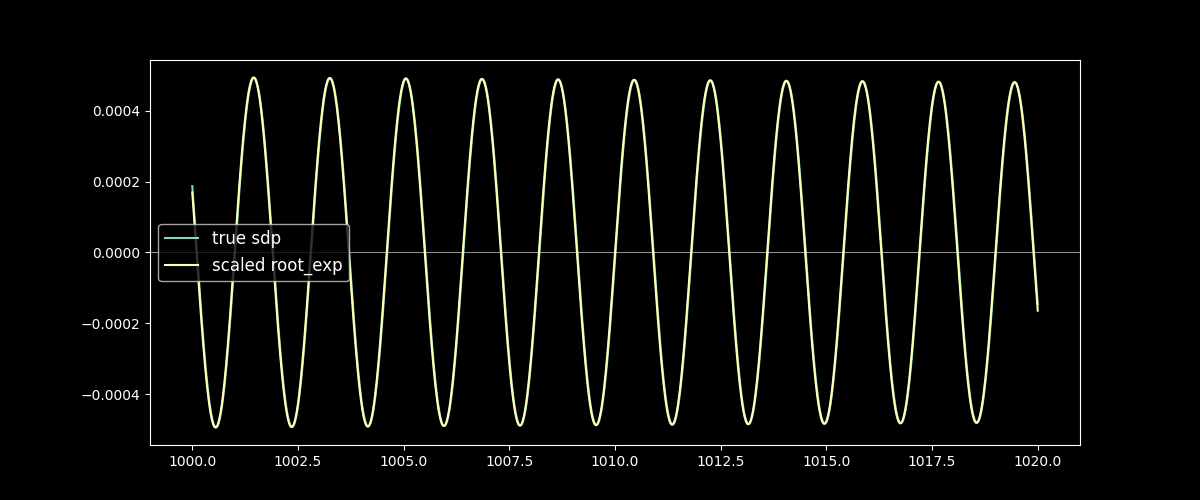

In [102]:
zs = np.linspace(1000, 1020, 1500)
A.plot_field_1d(sdp_z, xs=zs, plot_Rhos=False, label='true sdp');
# A.add_1d_plot(exp_ikz, .007, xs=zs)
A.add_1d_plot(root_exp, scalar, xs=zs, label='scaled root_exp')


### In the x-direction

In [135]:
C1 = (1 + 1j) / (2 * np.sqrt(np.pi))
Fp0 = A.dFdZ_approx(1e-5, 1e-8, paper_method=False)
integral_f0_Fp0 = A.radiation_transform_dZ_approx(1e-5, f0, dZ=1e-8, Lx=-b, Rx=b)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

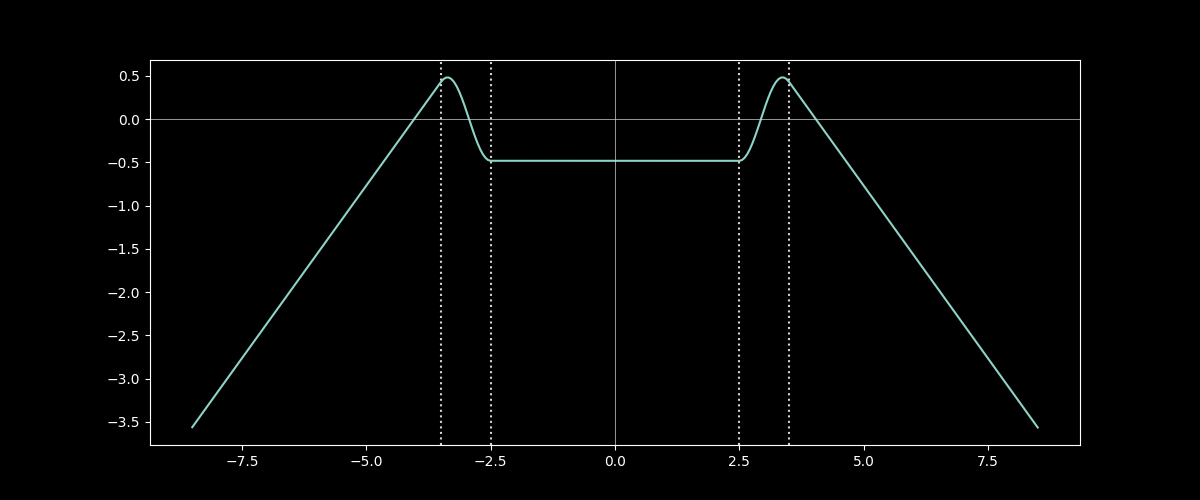

In [133]:
A.plot_field_1d(Fp0)

In [142]:
z0=1000
compare_form_true = lambda x: -sdp_x(x) / (C1 * integral_f0_Fp0 * root_exp(z0) * np.pi)
ratio_x_form_true_Fp0 = lambda x: compare_form_true(x) / Fp0(x)

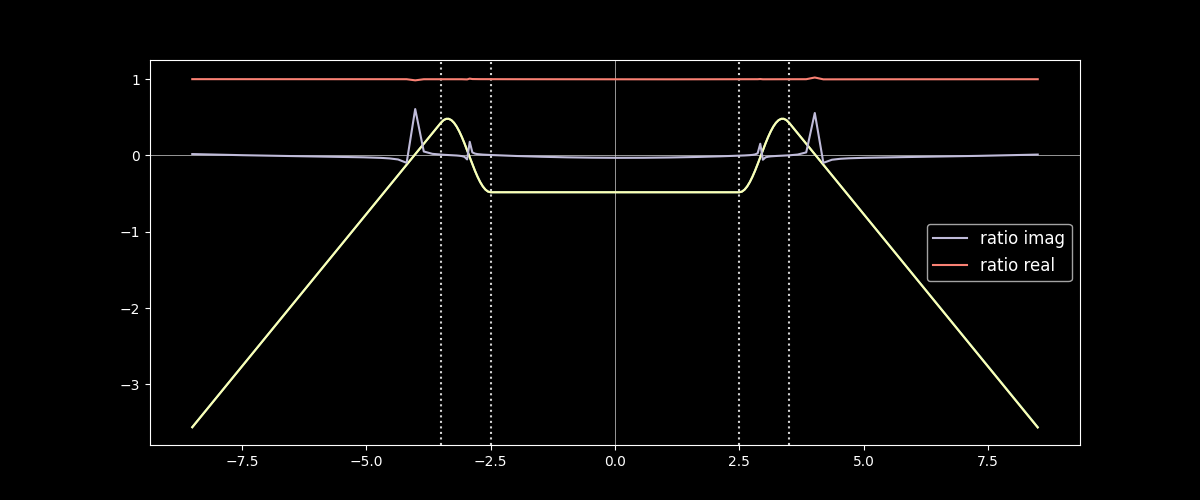

In [143]:
A.plot_field_1d(compare_form_true)
A.add_1d_plot(Fp0)
A.add_1d_plot(ratio_x_form_true_Fp0, part='imag', label='ratio imag')
A.add_1d_plot(ratio_x_form_true_Fp0, label='ratio real')